<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson03_CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 3. Simple CNN excerise
## 1. Improve lesson 2's code
## 2. Save the usually-used code
## 3. Try to implement your simple CNN using the MNIST dataset
## 4. Compare the results between CNN and DNN
## 5. Maybe it is slow. Try to improve the speed of the SGD


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

#Exercise 1. Do a warm up exercise with double moon dataset
## 1. Design a complex multiple classes classfication problem
## 2. Try to use lesson 2's code
## 3. Improve lesson 2's code


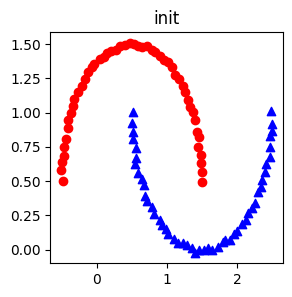

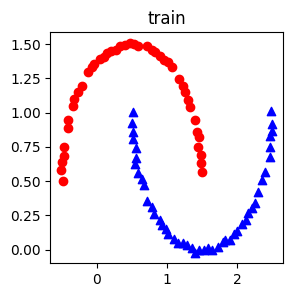

In [37]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 1
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
#plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [60]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

In [61]:
class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [72]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


(90, 2)
(90, 2)


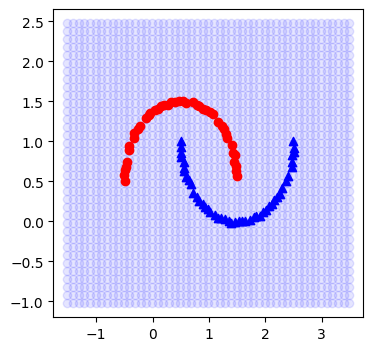

Epoch 1
-------------------------------
loss : 1.172979399109229


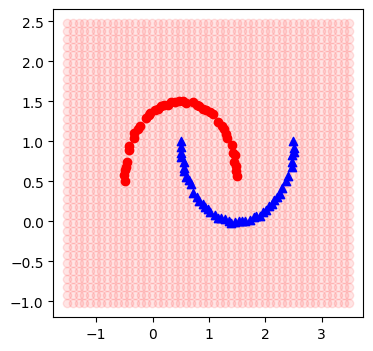

loss : 0.819301008057304


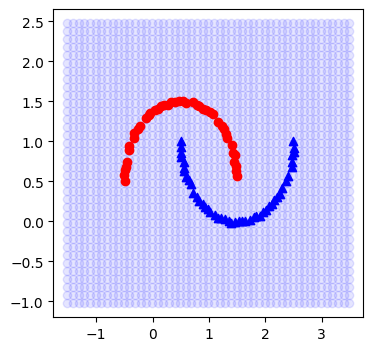

Epoch 2
-------------------------------
loss : 1.0226123799594


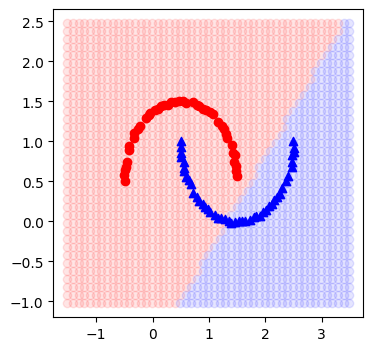

loss : 1.1774617255956037


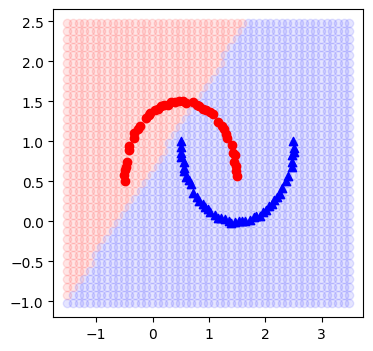

Epoch 3
-------------------------------
loss : 1.108111409568511


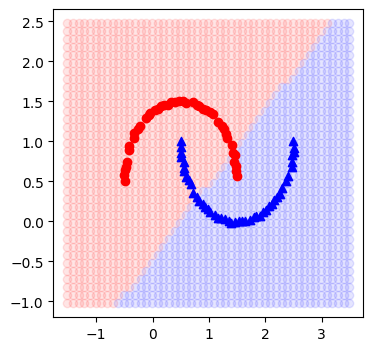

loss : 1.479069913637436


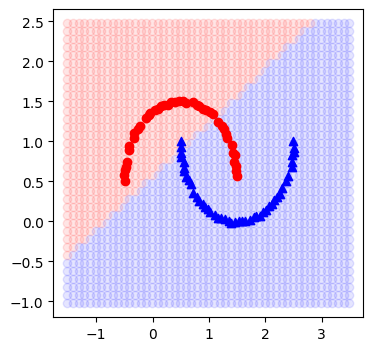

Epoch 4
-------------------------------
loss : 1.020050209320803


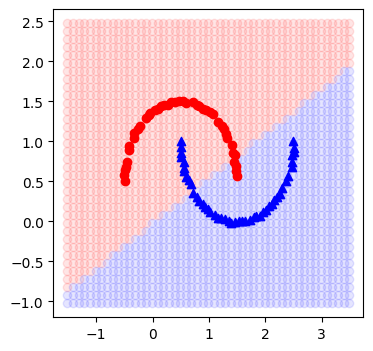

loss : 1.4349609368727343


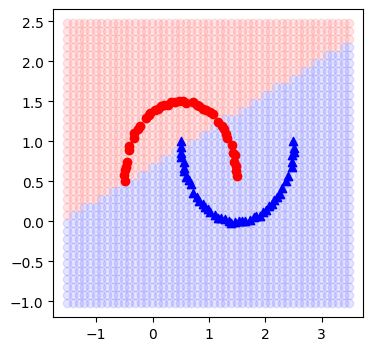

Epoch 5
-------------------------------
loss : 0.898992345767353


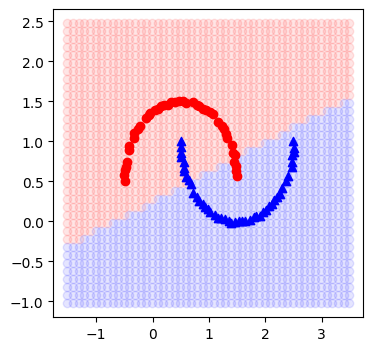

loss : 1.3865050182903156


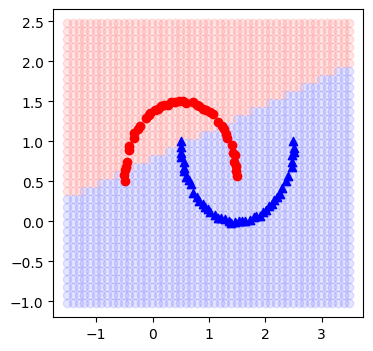

Epoch 6
-------------------------------
loss : 0.8702866994267304


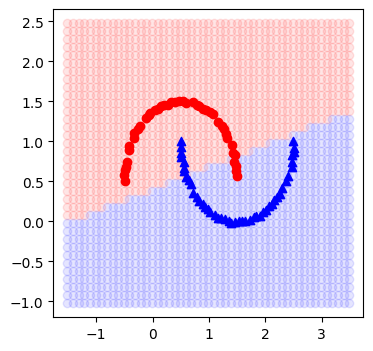

loss : 1.3554700205299413


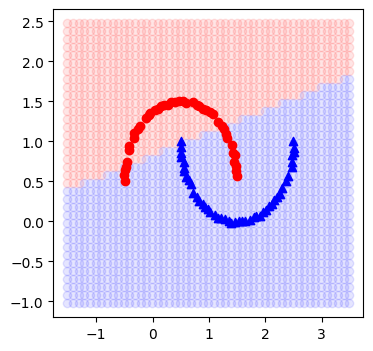

Epoch 7
-------------------------------
loss : 0.85931331220237


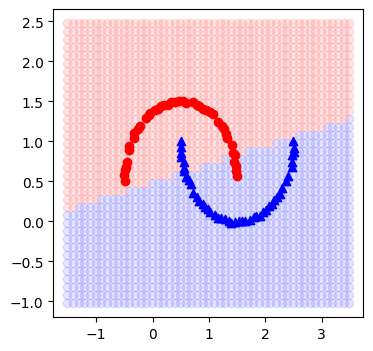

loss : 1.3597495913170865


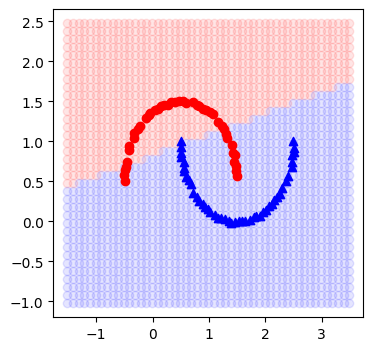

Epoch 8
-------------------------------
loss : 0.8450539124246449


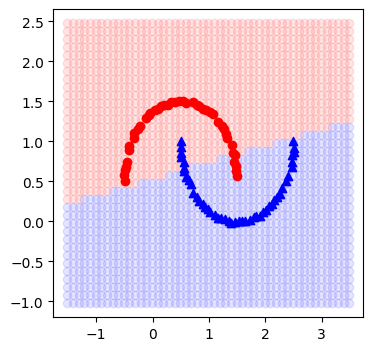

loss : 1.402175651316497


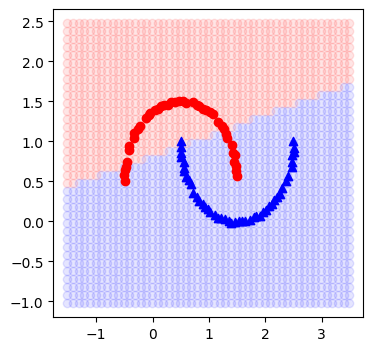

Epoch 9
-------------------------------
loss : 0.8275628046607839


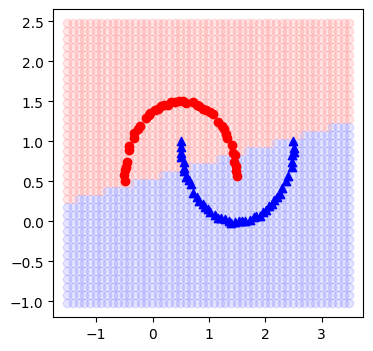

loss : 1.4640348760221742


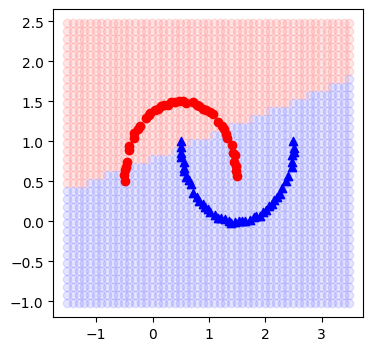

Epoch 10
-------------------------------
loss : 0.8617683747913084


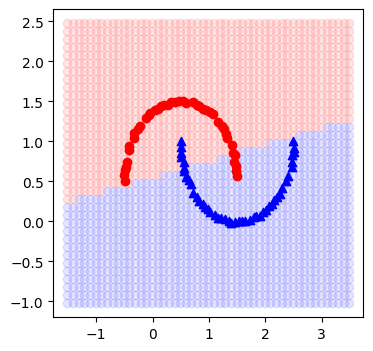

loss : 1.5353815783285785


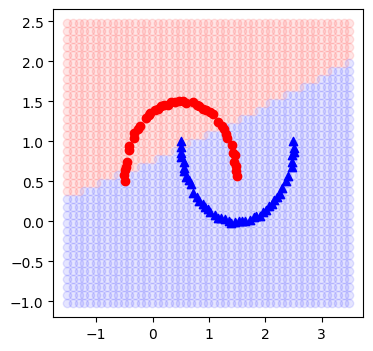

Epoch 11
-------------------------------
loss : 1.0215868450565297


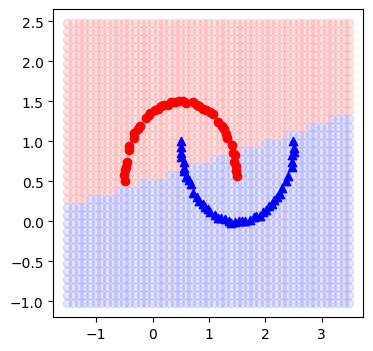

loss : 1.5572978180063115


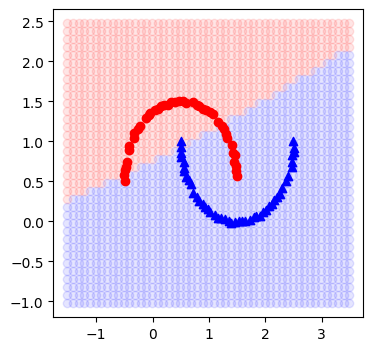

Epoch 12
-------------------------------
loss : 1.1510021081804007


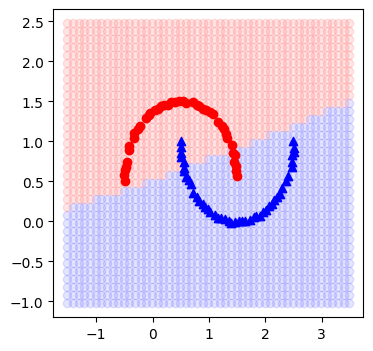

loss : 1.5523393807220551


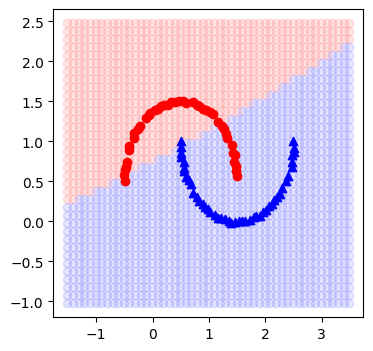

Epoch 13
-------------------------------
loss : 1.168741324951126


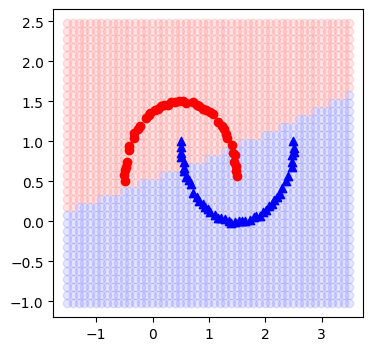

loss : 1.5556987721126565


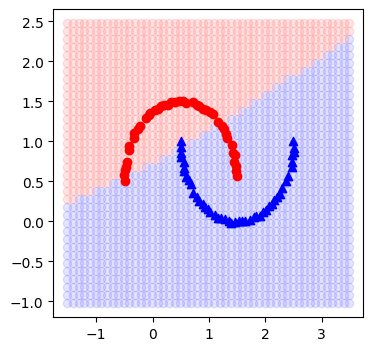

Epoch 14
-------------------------------
loss : 1.1594173781882786


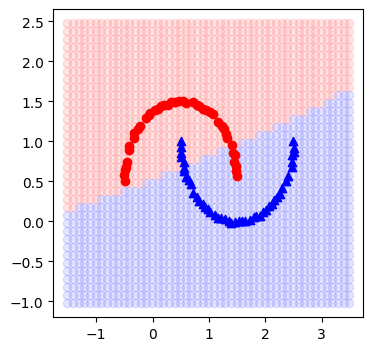

loss : 1.556056723604959


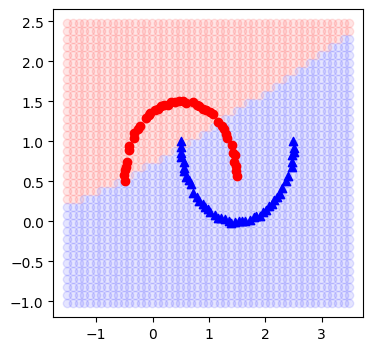

Epoch 15
-------------------------------
loss : 1.1373532740085186


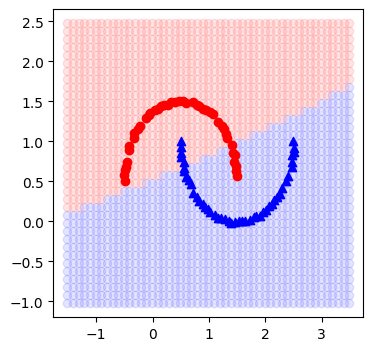

loss : 1.5440336863387156


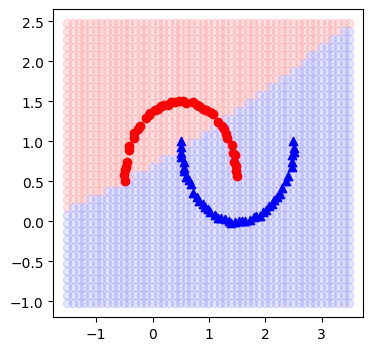

Epoch 16
-------------------------------
loss : 1.1099427760808447


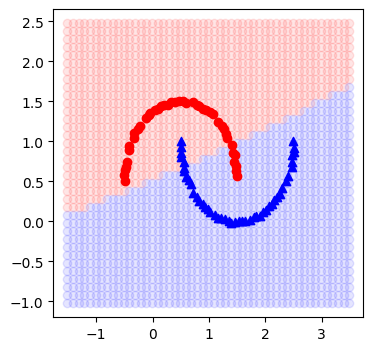

loss : 1.5220456588005793


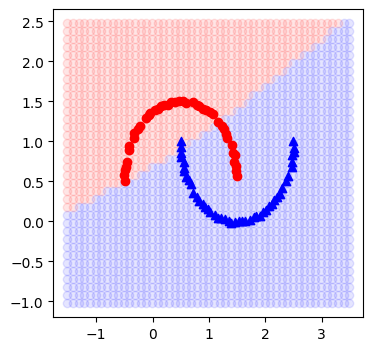

Epoch 17
-------------------------------
loss : 1.0823167770926871


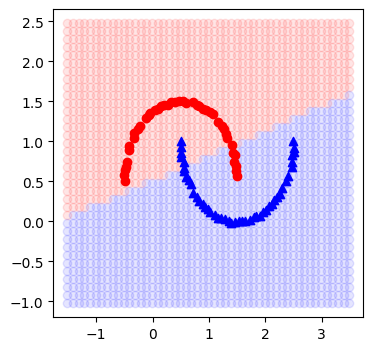

loss : 1.4987515959211972


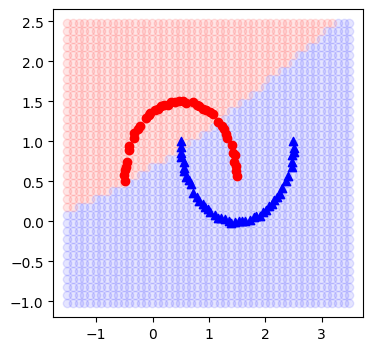

Epoch 18
-------------------------------
loss : 1.0574531913535192


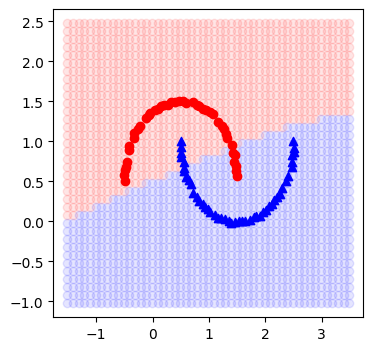

loss : 1.4796888273531847


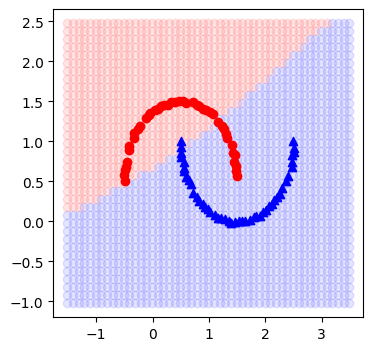

Epoch 19
-------------------------------
loss : 1.0361267608853022


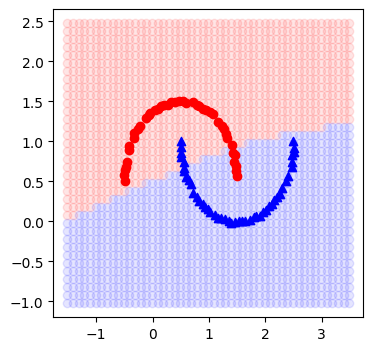

loss : 1.4657080416581034


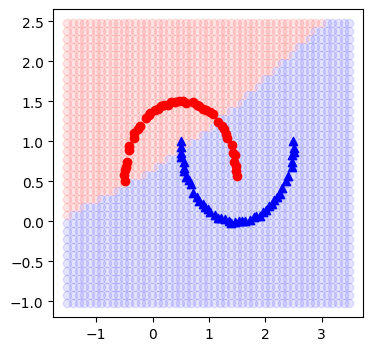

Epoch 20
-------------------------------
loss : 1.017711651751368


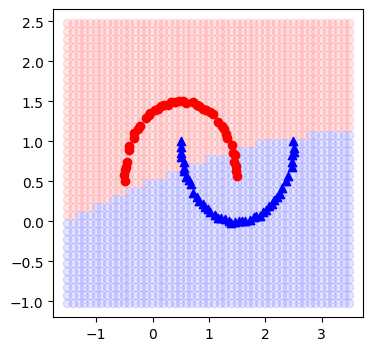

loss : 1.4556762637823724


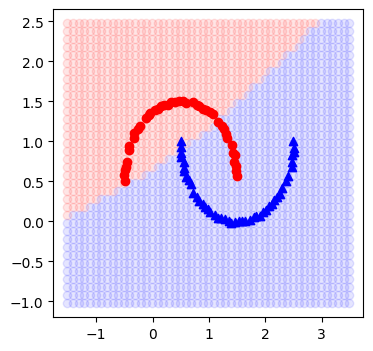

Epoch 21
-------------------------------
loss : 1.0013005004063353


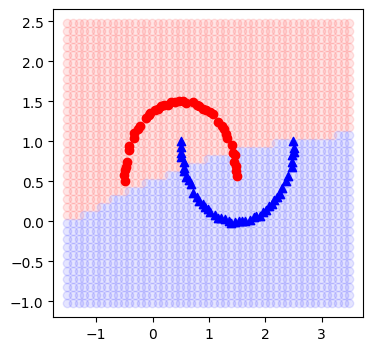

loss : 1.4482526349002771


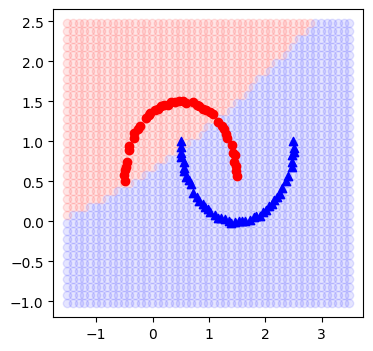

Epoch 22
-------------------------------
loss : 0.9862560512729865


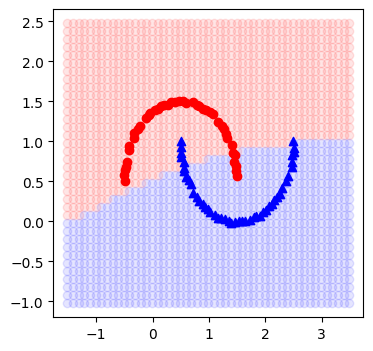

loss : 1.4423832680591782


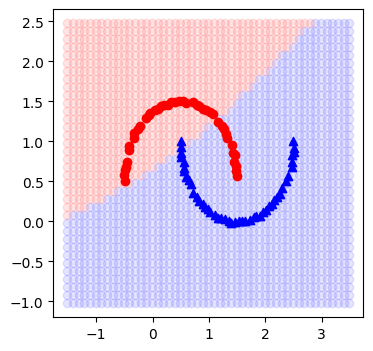

Epoch 23
-------------------------------
loss : 0.9722748938584032


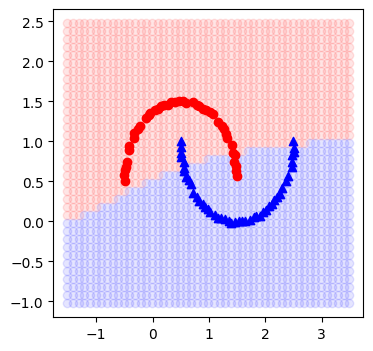

loss : 1.4373148557548907


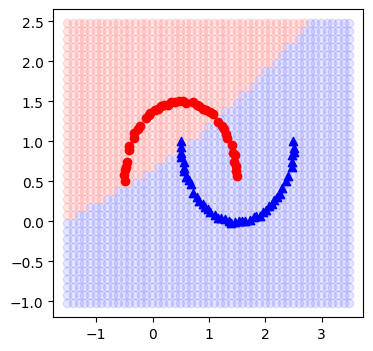

Epoch 24
-------------------------------
loss : 0.9592678147793094


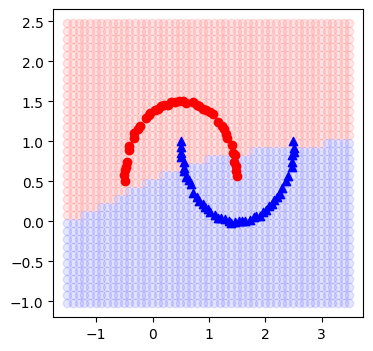

loss : 1.4325128092172306


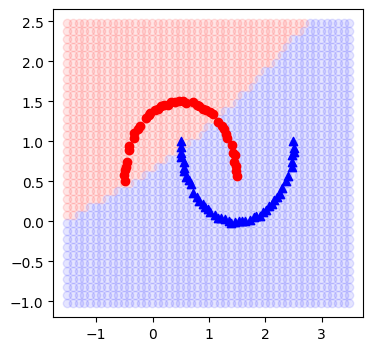

Epoch 25
-------------------------------
loss : 0.9472254145925222


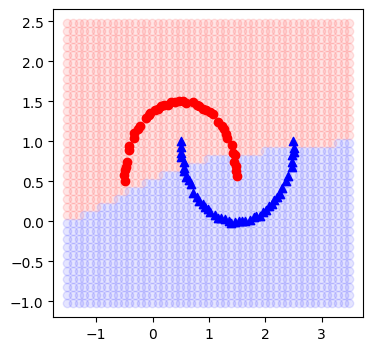

loss : 1.4275899626923076


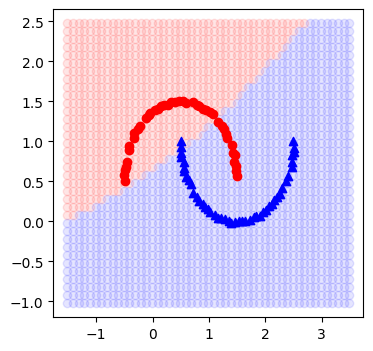

Epoch 26
-------------------------------
loss : 0.9361310317941278


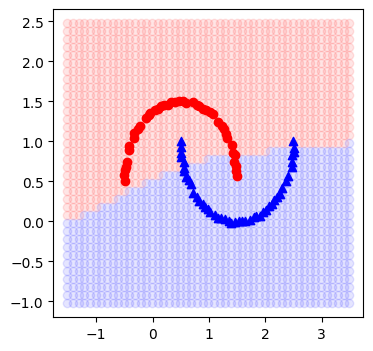

loss : 1.422260825804512


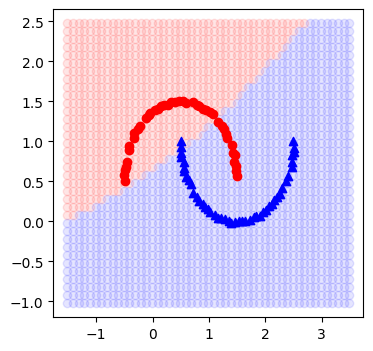

Epoch 27
-------------------------------
loss : 0.9259274522004535


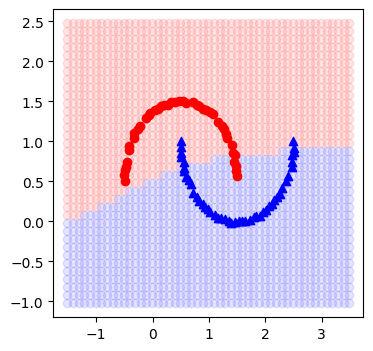

loss : 1.416313588797935


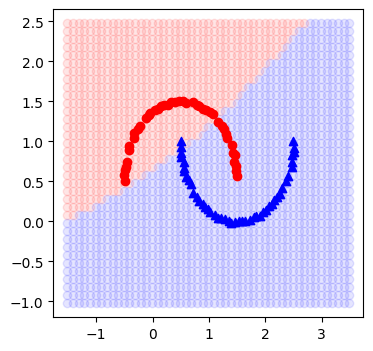

Epoch 28
-------------------------------
loss : 0.9165191636592586


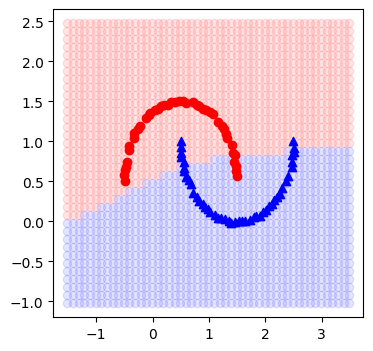

loss : 1.4095908785720248


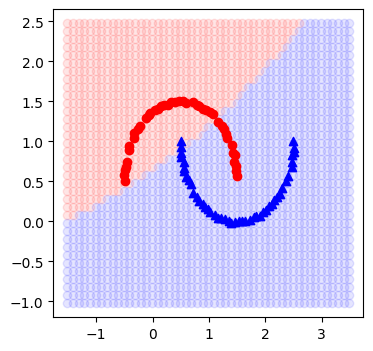

Epoch 29
-------------------------------
loss : 0.9077884941860379


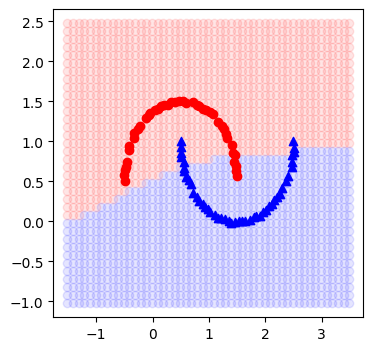

loss : 1.401974509119016


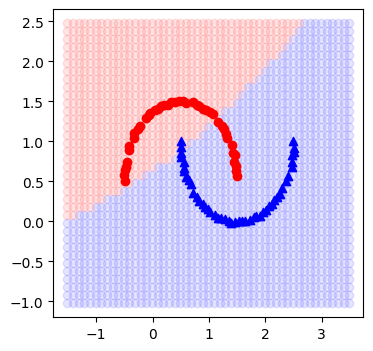

Epoch 30
-------------------------------
loss : 0.8996114385209034


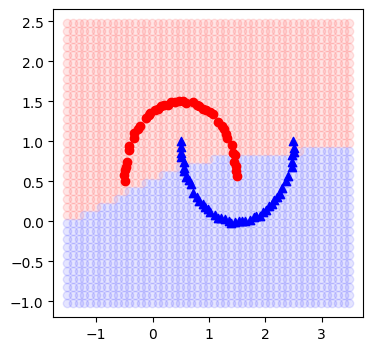

loss : 1.3933728124679194


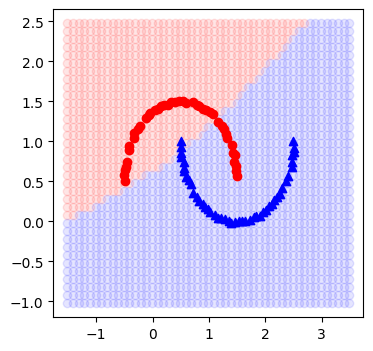

Epoch 31
-------------------------------
loss : 0.8918677054560148


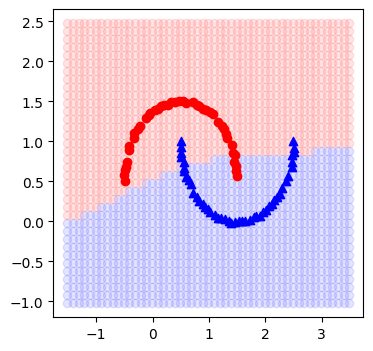

loss : 1.3837104012740307


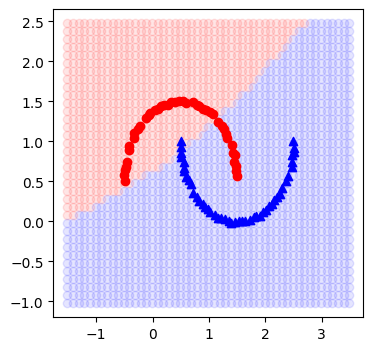

Epoch 32
-------------------------------
loss : 0.8844449464471081


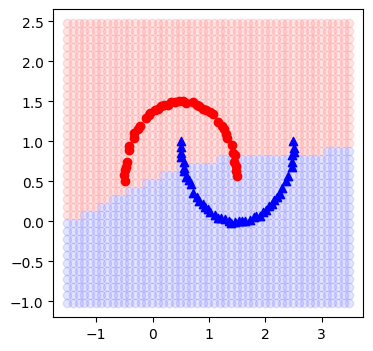

loss : 1.372920247263149


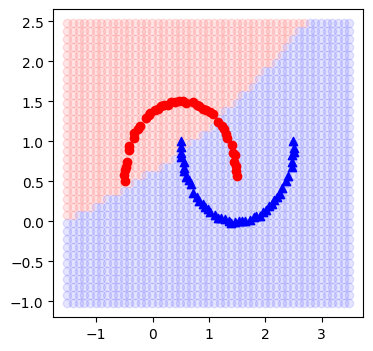

Epoch 33
-------------------------------
loss : 0.8772390764226208


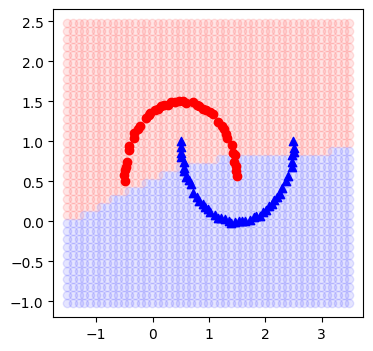

loss : 1.3609376223180794


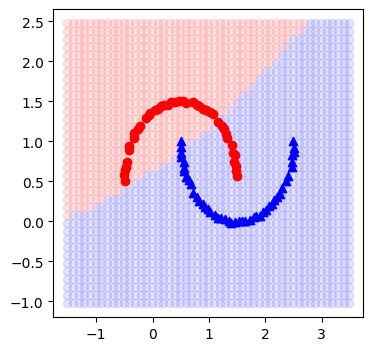

Epoch 34
-------------------------------
loss : 0.870152531951855


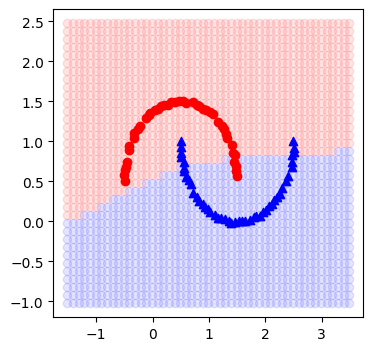

loss : 1.347695143268862


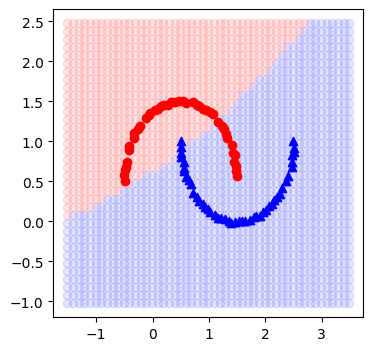

Epoch 35
-------------------------------
loss : 0.8630915536511979


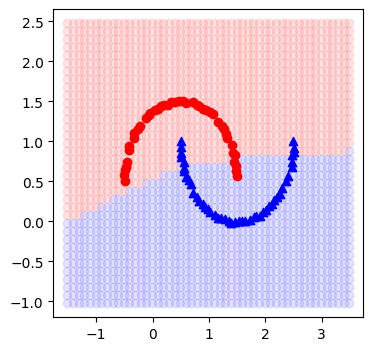

loss : 1.333117977298687


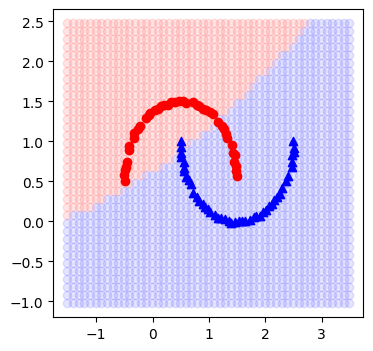

Epoch 36
-------------------------------
loss : 0.8559628247550605


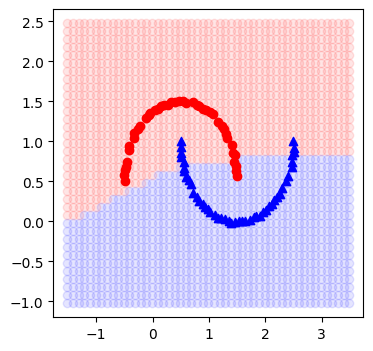

loss : 1.3171181589297292


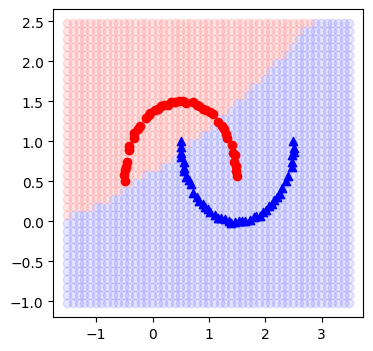

Epoch 37
-------------------------------
loss : 0.848669248305238


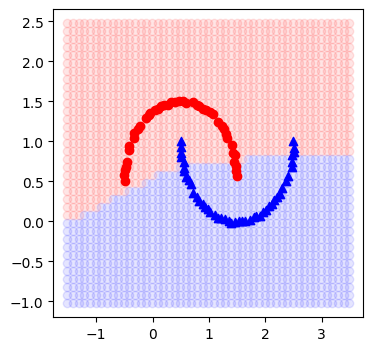

loss : 1.299586862357348


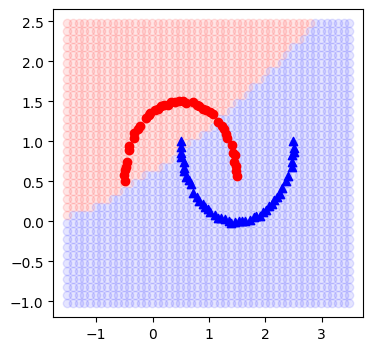

Epoch 38
-------------------------------
loss : 0.8411042585365686


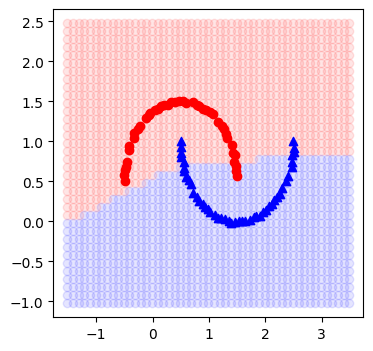

loss : 1.2803832941963476


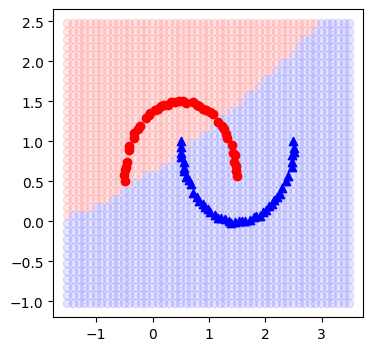

Epoch 39
-------------------------------
loss : 0.8331437189353627


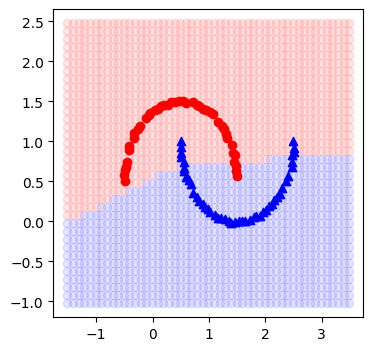

loss : 1.2593185904141655


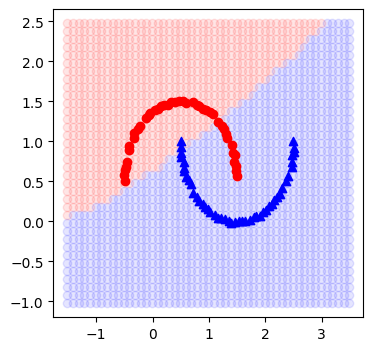

Epoch 40
-------------------------------
loss : 0.8246340404319614


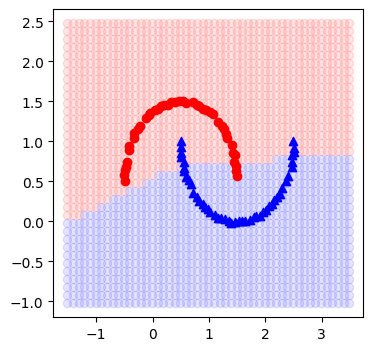

loss : 1.2361327738153736


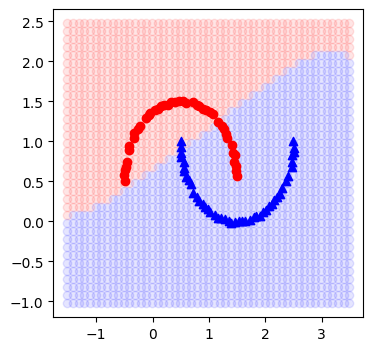

Epoch 41
-------------------------------
loss : 0.8153745666857861


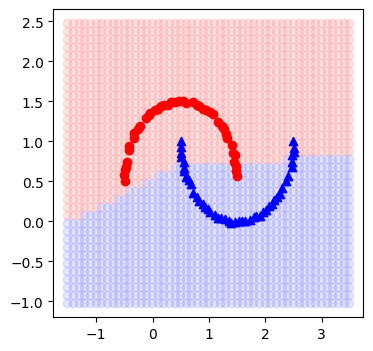

loss : 1.2104627047028476


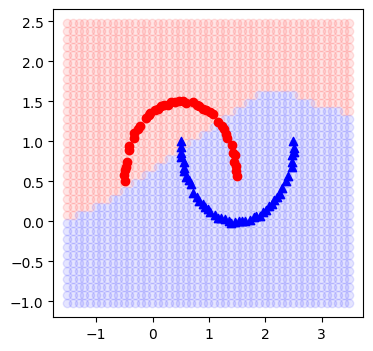

Epoch 42
-------------------------------
loss : 0.8050915028803873


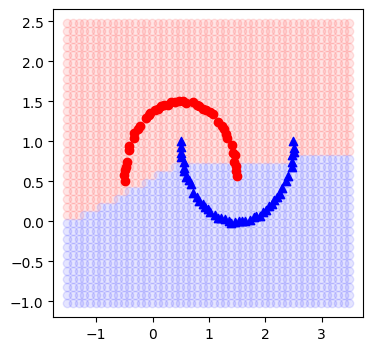

loss : 1.1817996828304411


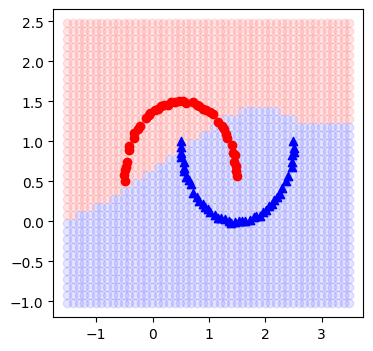

Epoch 43
-------------------------------
loss : 0.7933999264640171


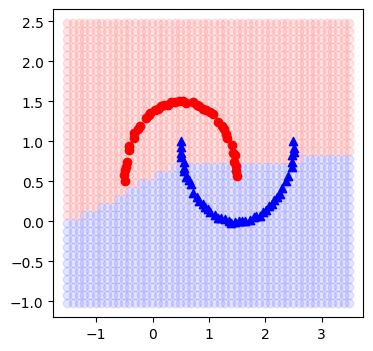

loss : 1.149438264543314


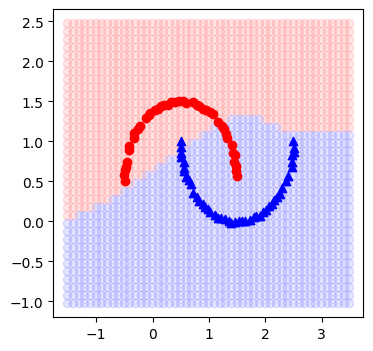

Epoch 44
-------------------------------
loss : 0.7797506034331952


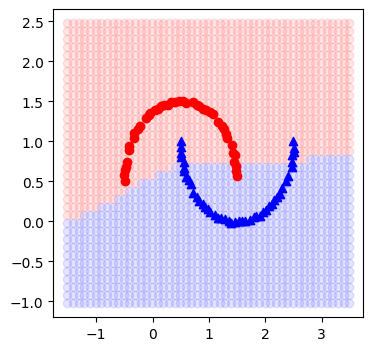

loss : 1.1124251358675425


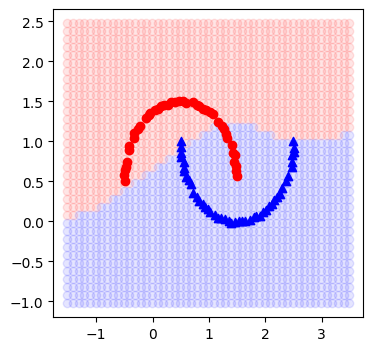

Epoch 45
-------------------------------
loss : 0.7633619767212904


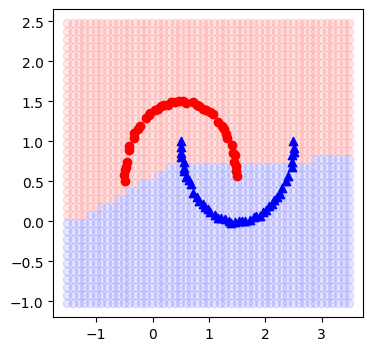

loss : 1.069531065866002


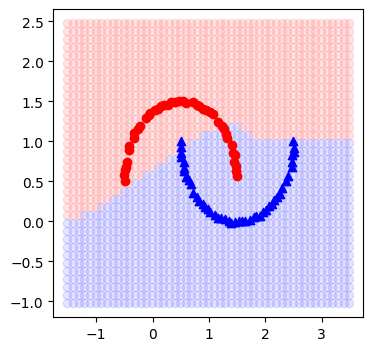

Epoch 46
-------------------------------
loss : 0.743150348722362


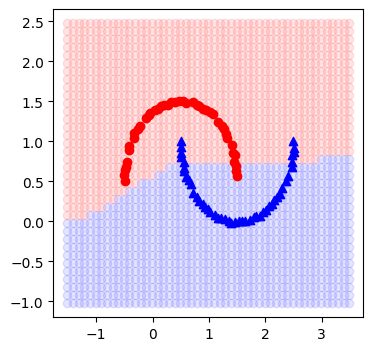

loss : 1.0192911930716742


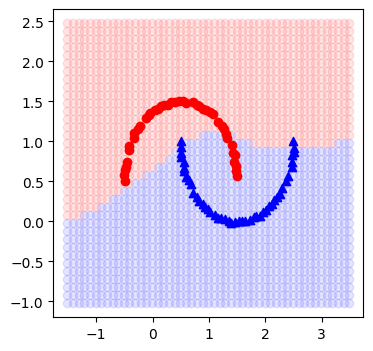

Epoch 47
-------------------------------
loss : 0.7177009891254771


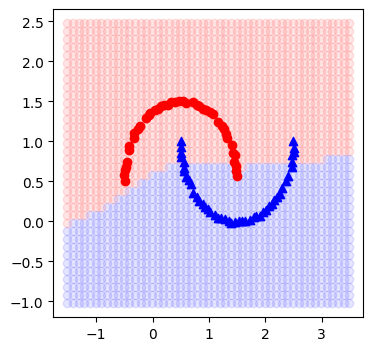

loss : 0.9601865845138686


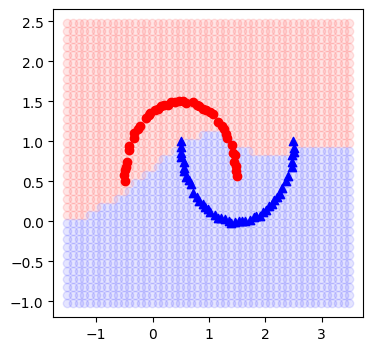

Epoch 48
-------------------------------
loss : 0.685370649530633


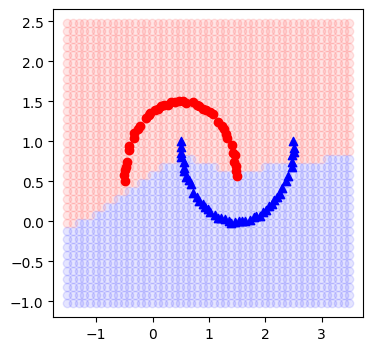

loss : 0.8910596933261943


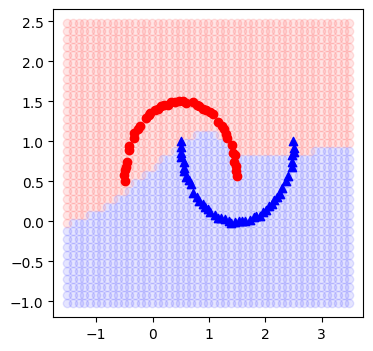

Epoch 49
-------------------------------
loss : 0.6446480018908927


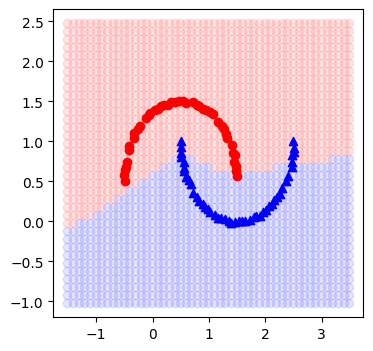

loss : 0.8118080747349106


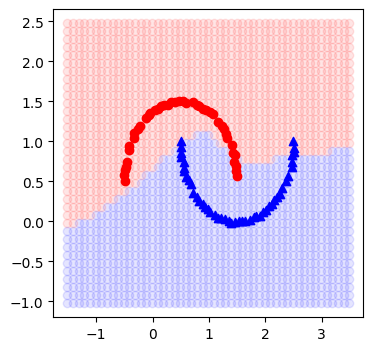

Epoch 50
-------------------------------
loss : 0.5948461573334017


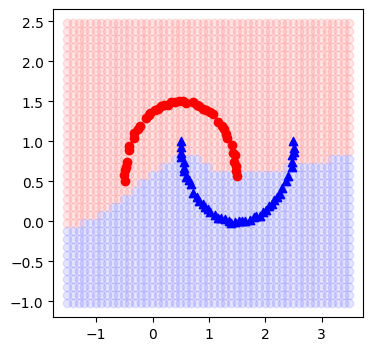

loss : 0.724160004083594


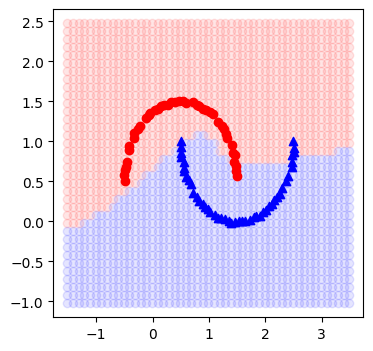

Epoch 51
-------------------------------
loss : 0.5369697480232539


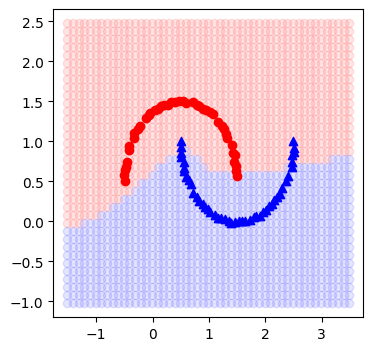

loss : 0.6319673740123432


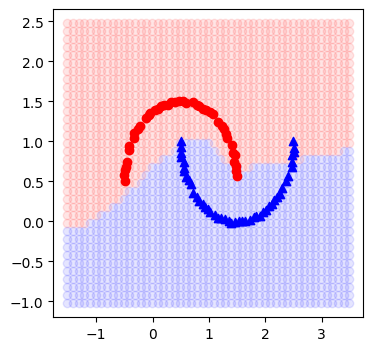

Epoch 52
-------------------------------
loss : 0.47420664907492227


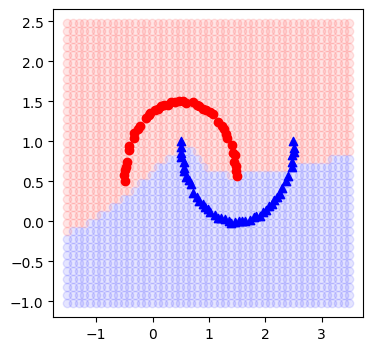

loss : 0.540497848072095


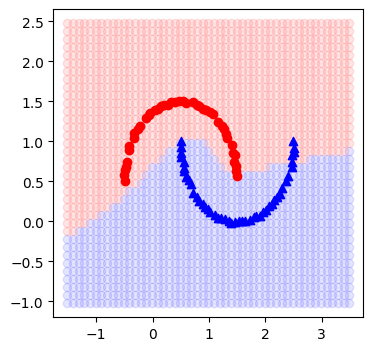

Epoch 53
-------------------------------
loss : 0.4113419806756474


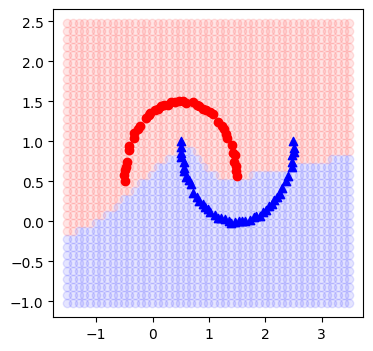

loss : 0.4549612710659446


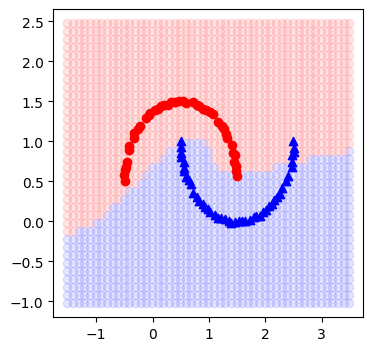

Epoch 54
-------------------------------
loss : 0.3530990854940597


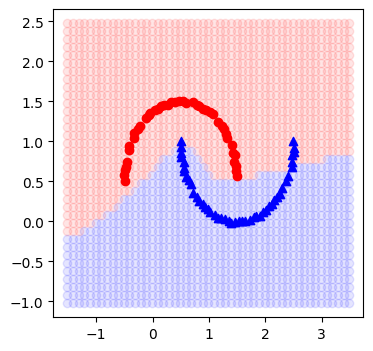

loss : 0.37916003633094336


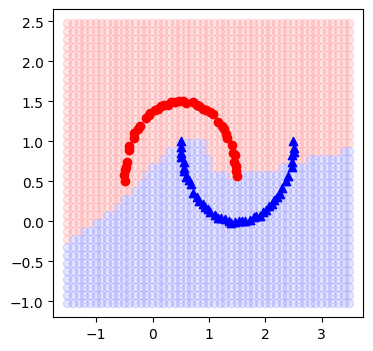

Epoch 55
-------------------------------
loss : 0.3025058771991537


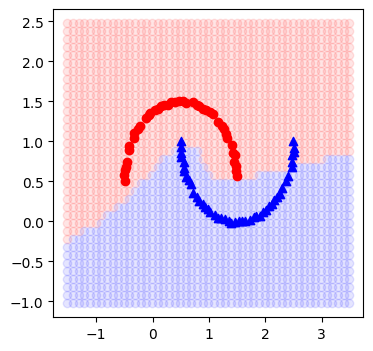

loss : 0.3149204600950762


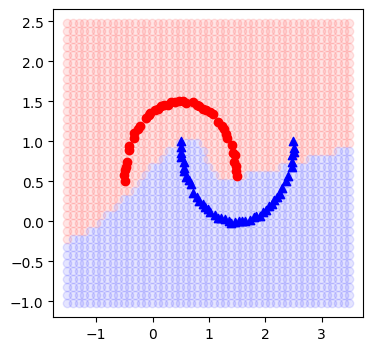

Epoch 56
-------------------------------
loss : 0.2603384322004619


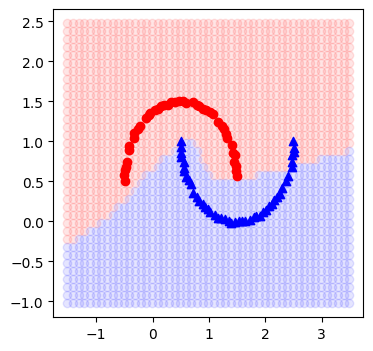

loss : 0.2623027738385576


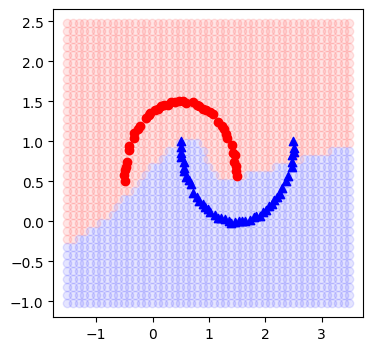

Epoch 57
-------------------------------
loss : 0.22550127039623993


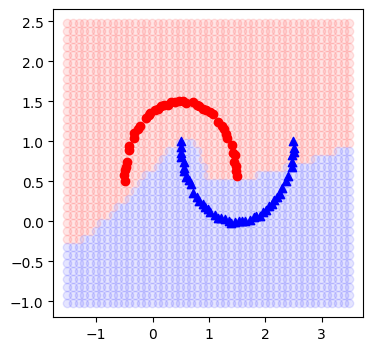

loss : 0.22025498830250964


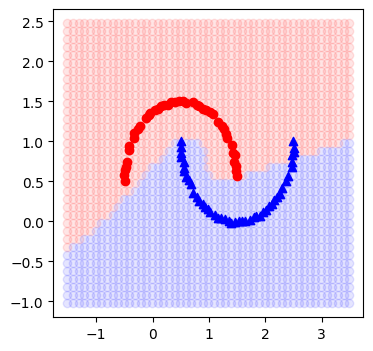

Epoch 58
-------------------------------
loss : 0.19524047768222472


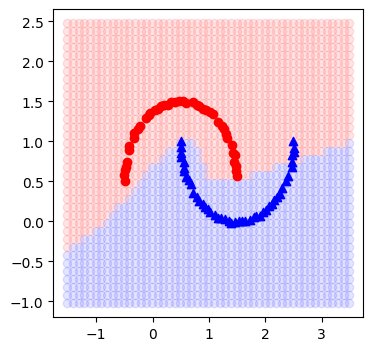

loss : 0.1871798666391687


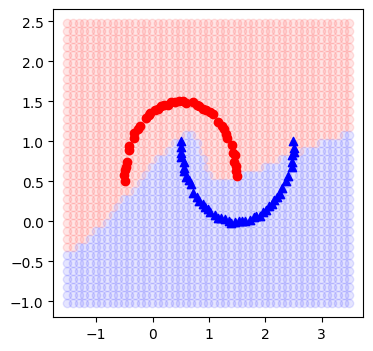

Epoch 59
-------------------------------
loss : 0.16388521062885605


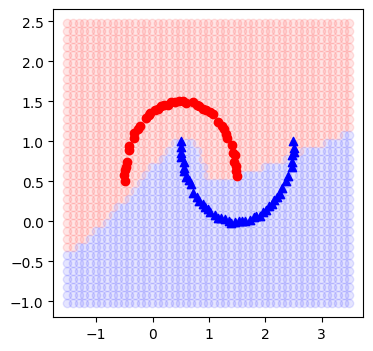

loss : 0.16104499129311087


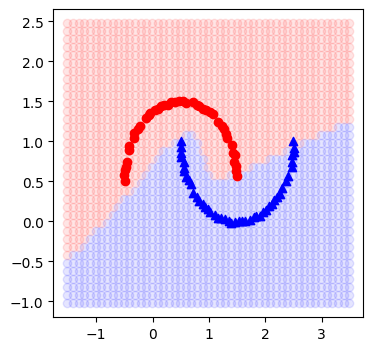

Epoch 60
-------------------------------
loss : 0.12381276132524113


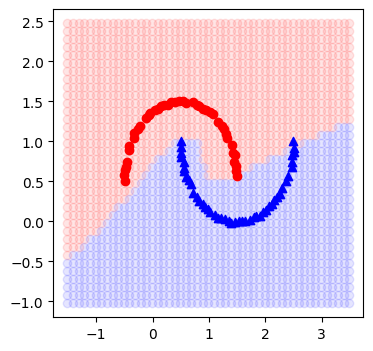

loss : 0.1361441194657553


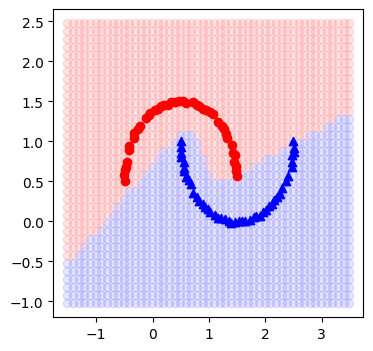

Epoch 61
-------------------------------
loss : 0.08441668672056224


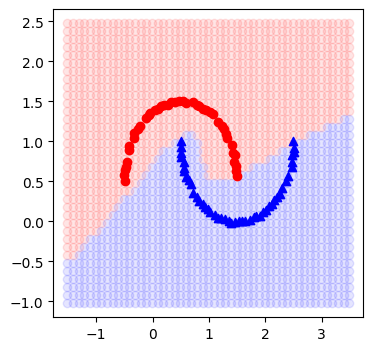

loss : 0.11154556266876522


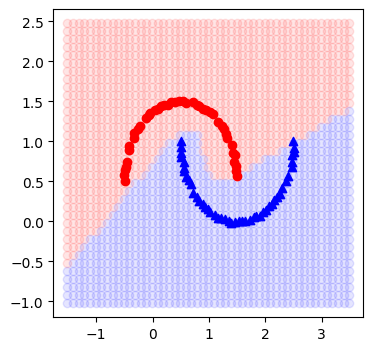

Epoch 62
-------------------------------
loss : 0.06624753392518927


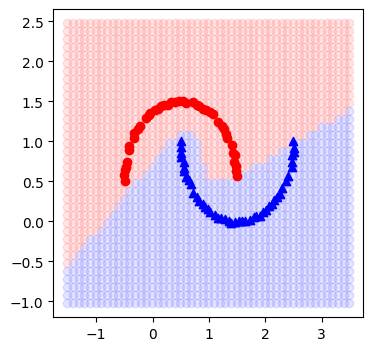

loss : 0.09910478761429985


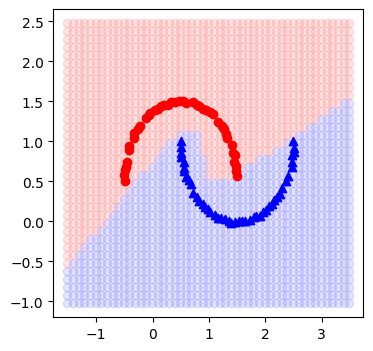

Epoch 63
-------------------------------
loss : 0.048233515666726276


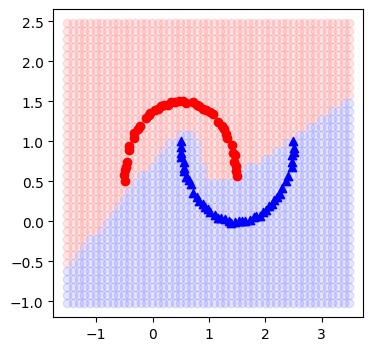

loss : 0.09094258561170872


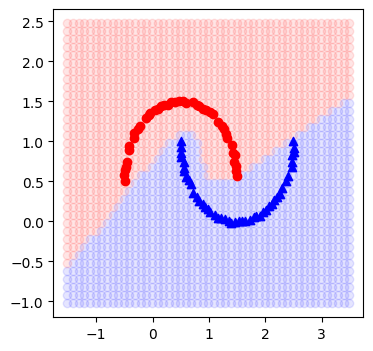

Epoch 64
-------------------------------
loss : 0.03373733390543483


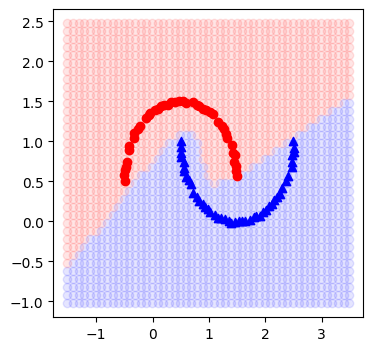

loss : 0.07537770158279558


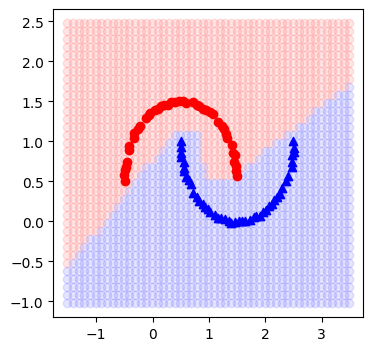

Epoch 65
-------------------------------
loss : 0.024586797278582408


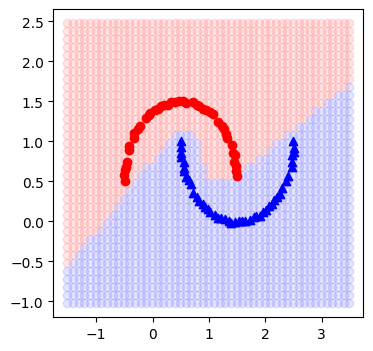

loss : 0.05638024248804903


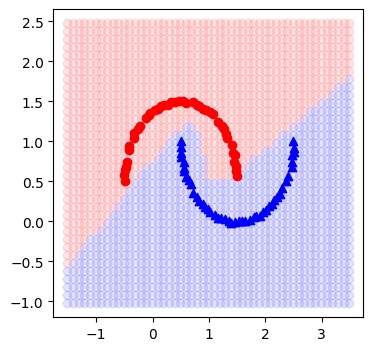

Epoch 66
-------------------------------
loss : 0.0192860847917166


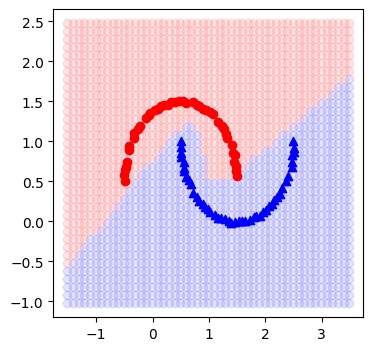

loss : 0.044161390111989454


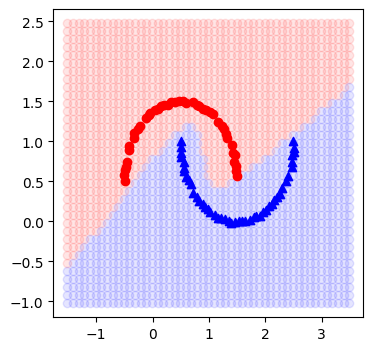

Epoch 67
-------------------------------
loss : 0.012459791572444676


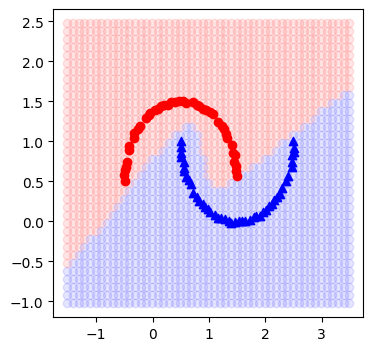

loss : 0.030851631138875145


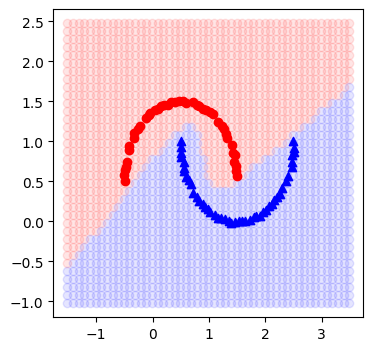

Epoch 68
-------------------------------
loss : 0.009482138871869935


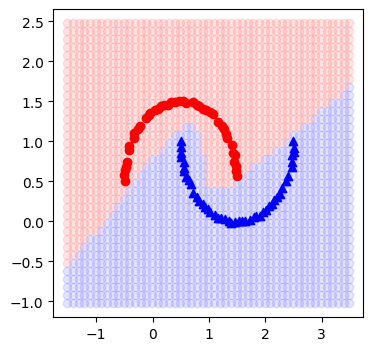

loss : 0.021717654285414292


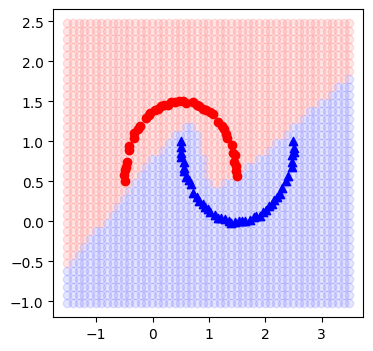

Epoch 69
-------------------------------
loss : 0.008385985298216268


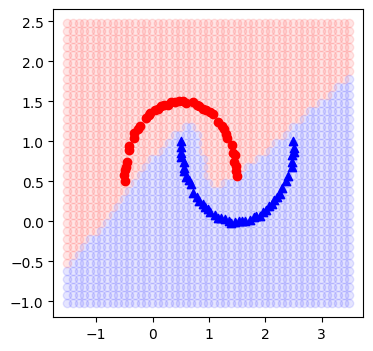

loss : 0.016319919150347334


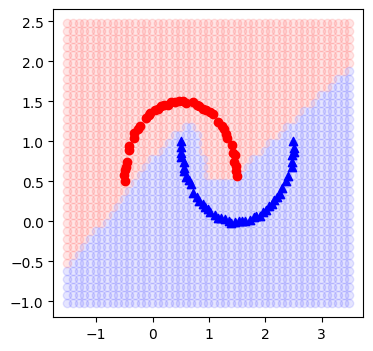

Epoch 70
-------------------------------
loss : 0.007033207334963929


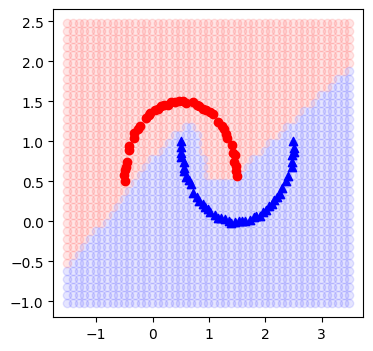

loss : 0.012678266784789562


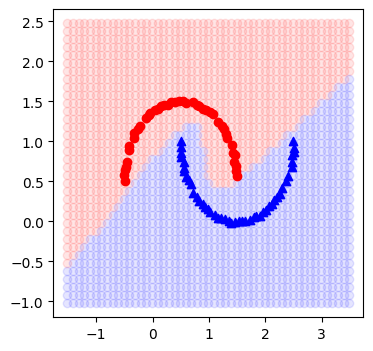

Epoch 71
-------------------------------
loss : 0.004677204000259221


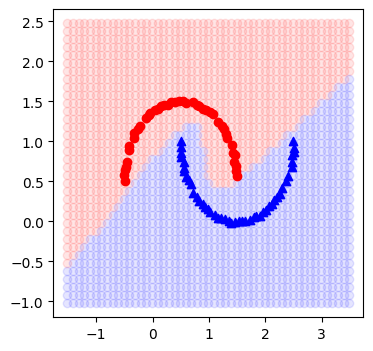

loss : 0.014545016740527477


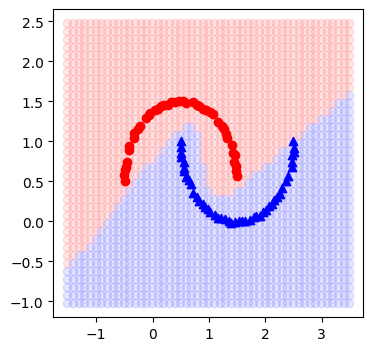

Epoch 72
-------------------------------
loss : 0.0026974397714920077


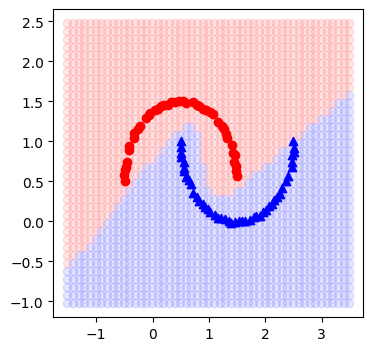

loss : 0.011861950241744044


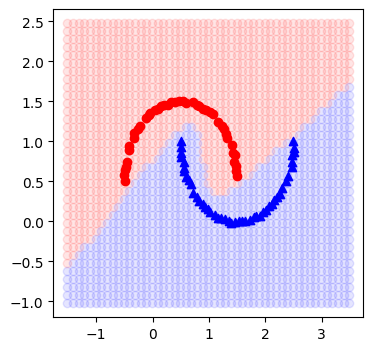

Epoch 73
-------------------------------
loss : 0.0024584033597525473


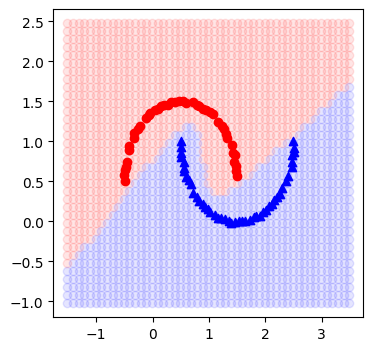

loss : 0.011222039723029528


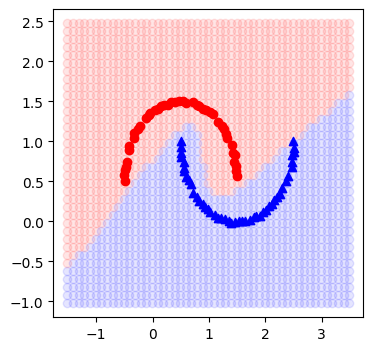

Epoch 74
-------------------------------
loss : 0.0019406487213320036


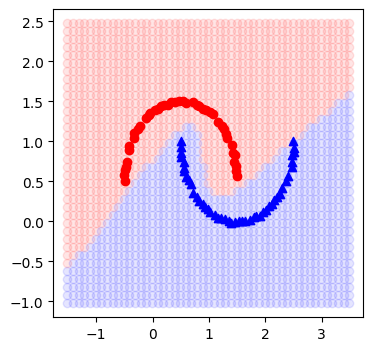

loss : 0.008881948200163099


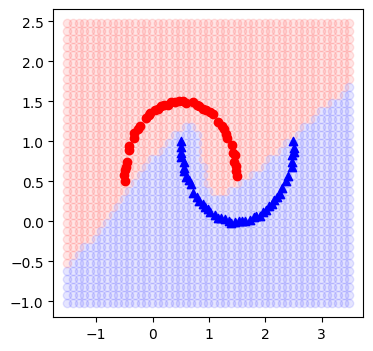

Epoch 75
-------------------------------
loss : 0.001873779218870824


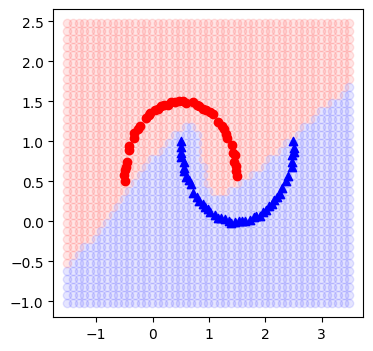

loss : 0.008502168415059849


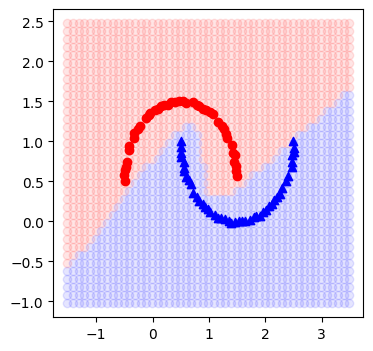

Epoch 76
-------------------------------
loss : 0.0015472142937420625


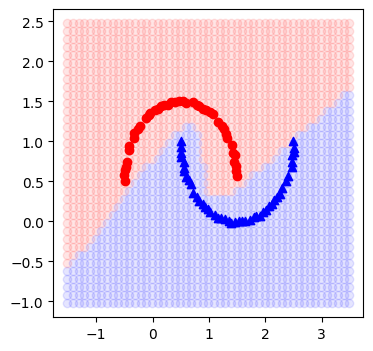

loss : 0.0076955826064048485


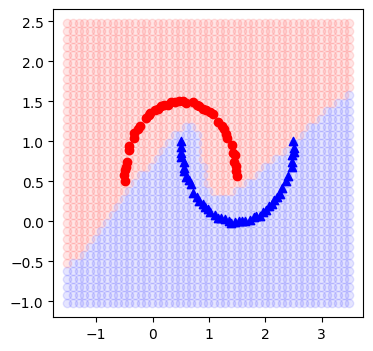

Epoch 77
-------------------------------
loss : 0.0012604456148703903


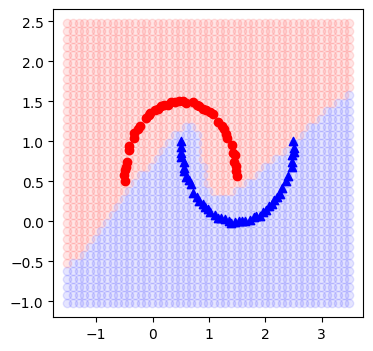

loss : 0.006032865872828144


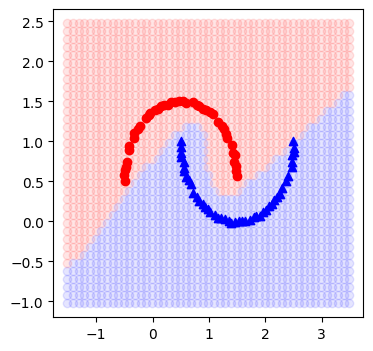

Epoch 78
-------------------------------
loss : 0.0015366187226511059


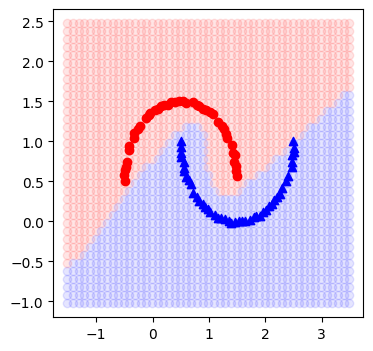

loss : 0.005920989226858066


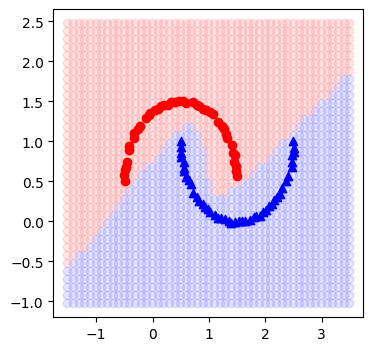

Epoch 79
-------------------------------
loss : 0.0011716443519160353


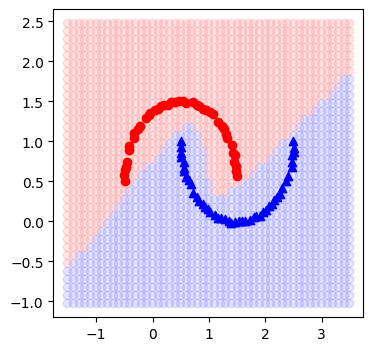

loss : 0.004795252042648575


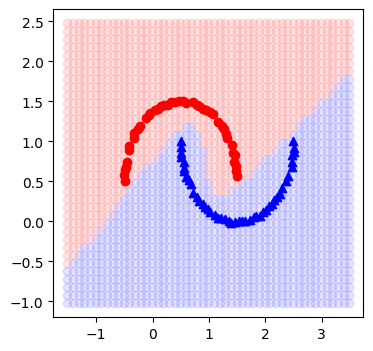

Epoch 80
-------------------------------
loss : 0.0013137331138110865


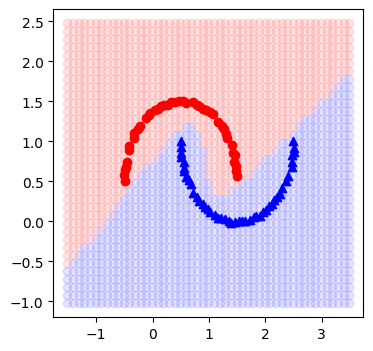

loss : 0.0042701096567454005


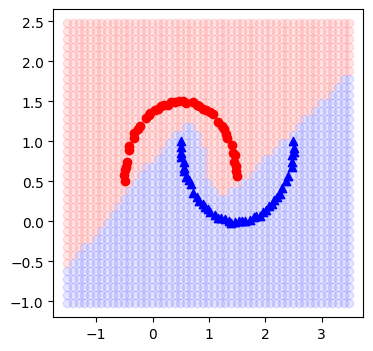

In [76]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

print(train_features.shape)
print(train_labels.shape)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

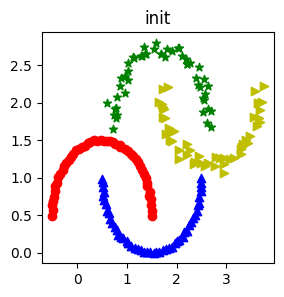

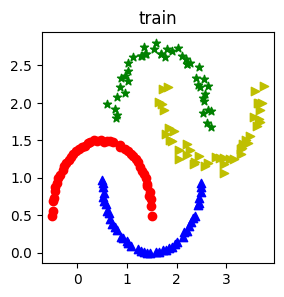

In [77]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 2
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [80]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


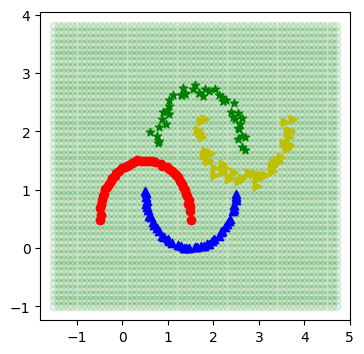

Epoch 1
-------------------------------
loss : 1.7283737754481967


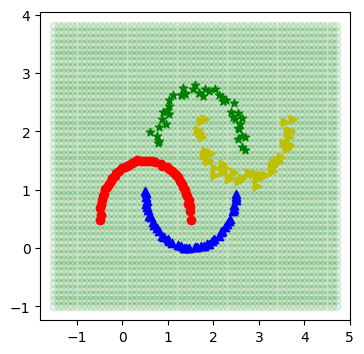

loss : 0.789519353211368


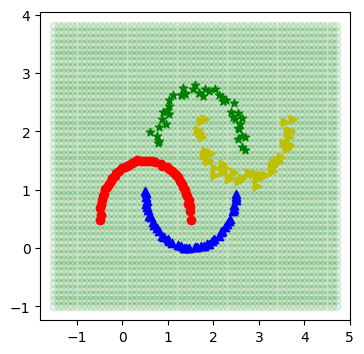

Epoch 11
-------------------------------
loss : 0.043676246663484034


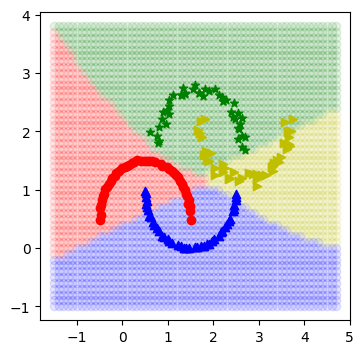

loss : 0.07016879692739085


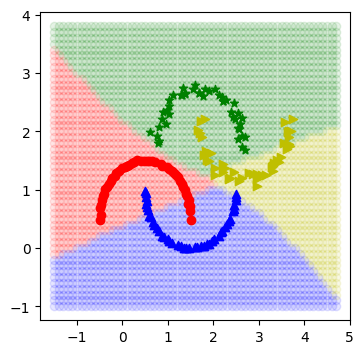

Epoch 21
-------------------------------
loss : 0.029050984874912582


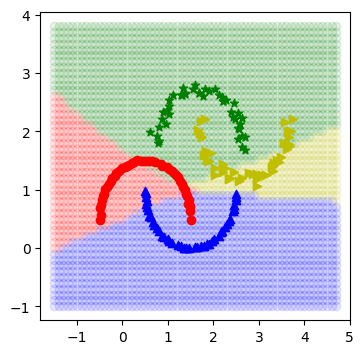

loss : 0.042985647106324194


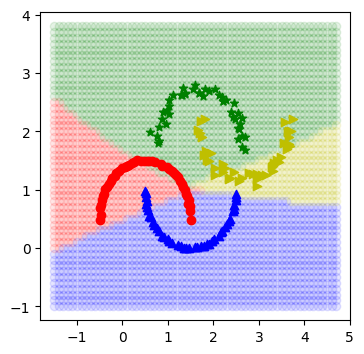

Epoch 31
-------------------------------
loss : 0.012899860394271356


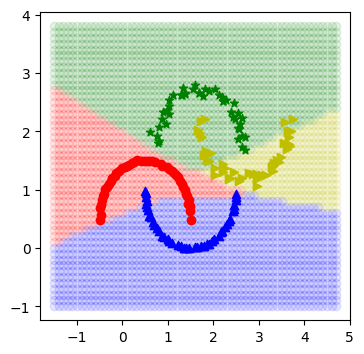

loss : 0.06316310020724304


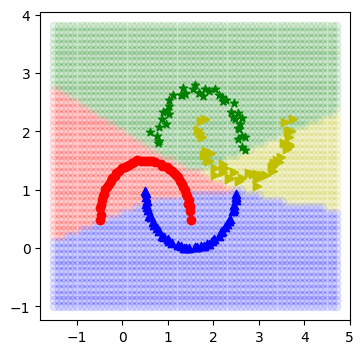

Epoch 41
-------------------------------
loss : 0.02398375499373968


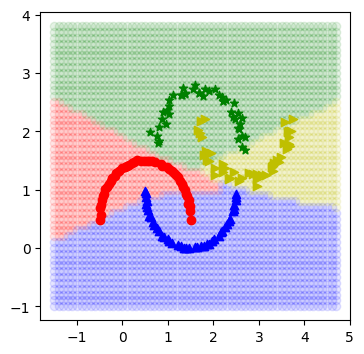

loss : 0.09277641931203888


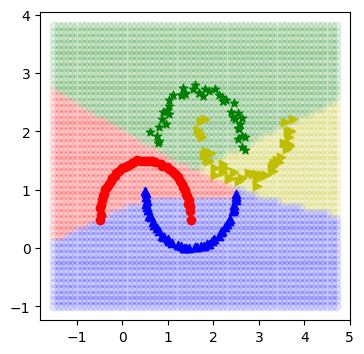

Epoch 51
-------------------------------
loss : 0.09322310177507807


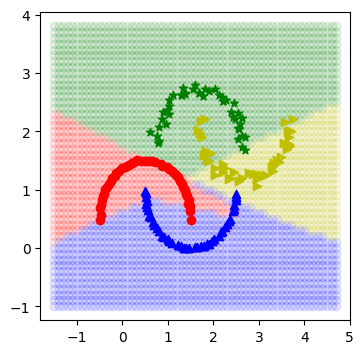

loss : 0.0505815866611156


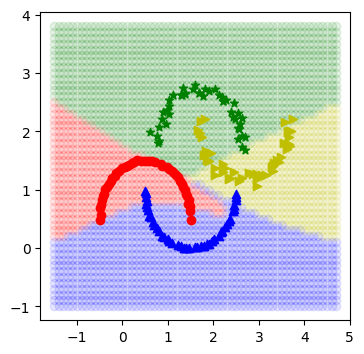

Epoch 61
-------------------------------
loss : 0.11378694959528306


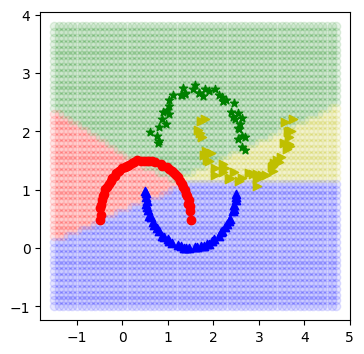

loss : 0.03165136994084013


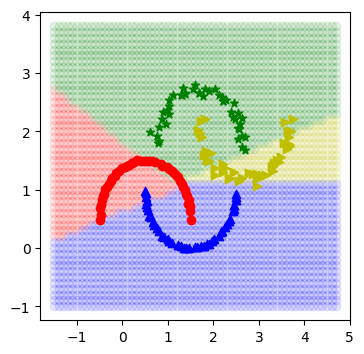

Epoch 71
-------------------------------
loss : 0.1474791999934724


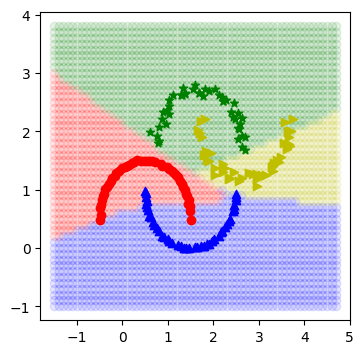

loss : 0.05865027605623168


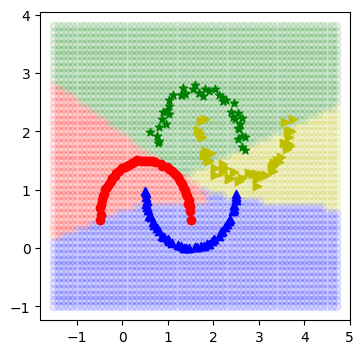

In [99]:
demo_neuron = SimpleDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 10 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 2. Warm up exercise 2 with double moon dataset
## 1. Try to use a complex DNN to fix a multiple classes classfication problem


In [100]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

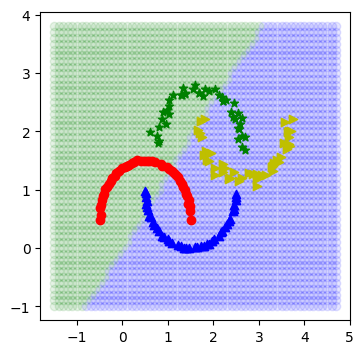

Epoch 1
-------------------------------
loss : 2.0038304220308123


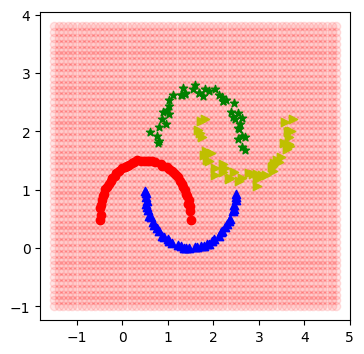

loss : 0.7388245992400384


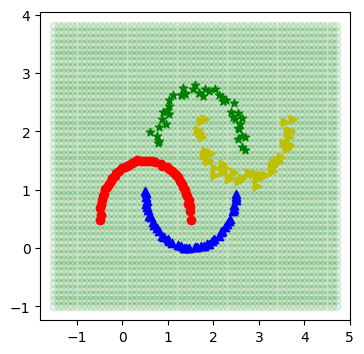

Epoch 51
-------------------------------
loss : 0.14004173850359125


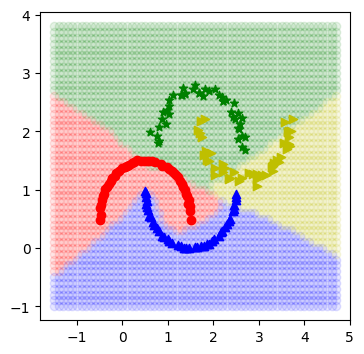

loss : 0.09162989111835708


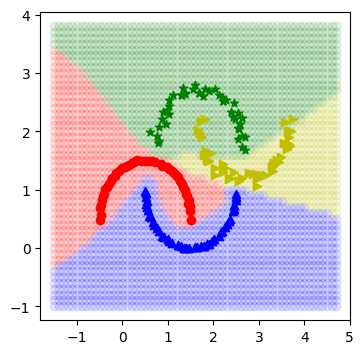

Epoch 101
-------------------------------
loss : 0.0013185016102497688


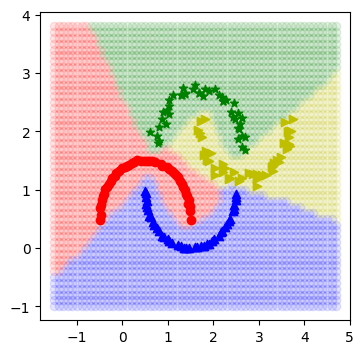

loss : 0.06781831731135457


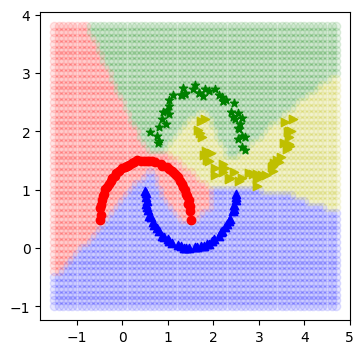

Epoch 151
-------------------------------
loss : 0.0007650758927155546


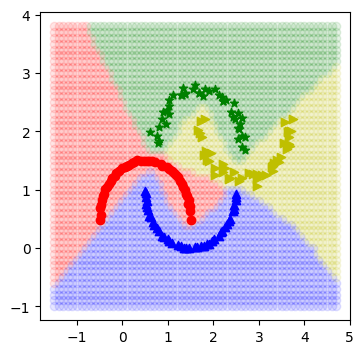

loss : 0.0023372473649931687


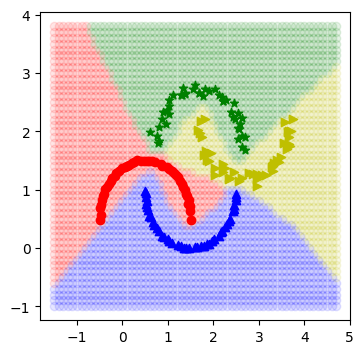

In [102]:
demo_neuron = ComplexDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 50 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 50 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)